In [ ]:
import os
import importlib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

True

In [2]:
# import data
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, os.path.pardir, "data")
file_name = 'cohort_data.csv'
file_path = os.path.join(data_dir, file_name)

cohort = pd.read_csv(file_path)

In [ ]:
# convert data types
cohort['user_id'] = cohort['user_id'].astype(str)
cohort['max_user_date'] = pd.to_datetime(cohort['max_user_date'])
cohort['min_user_date'] = pd.to_datetime(cohort['min_user_date'])
cohort['last_trip_date'] = pd.to_datetime(cohort['last_trip_date'])

In [ ]:
# create user cohorts by first session month

def get_date_int(df: pd.DataFrame, column: str) -> tuple:
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day


cohort_year, cohort_month, _ = get_date_int(cohort, 'min_user_date')
trip_year, trip_month, _ = get_date_int(cohort, 'last_trip_date')

years_diff = trip_year - cohort_year
months_diff = trip_month - cohort_month

cohort['min_user_month'] = cohort['min_user_date'].dt.month
cohort['last_trip_month'] = cohort['last_trip_date'].dt.month

cohort['cohort_index'] = years_diff * 12 + months_diff + 1


# convert cohorts to category

cohort['min_user_month'] = cohort['min_user_month'].astype('category')
cohort['cohort_index'] = cohort['cohort_index'].astype('category')

cohort['min_user_month'] = cohort['min_user_month'].cat.reorder_categories([7, 8, 9, 10, 11, 12, 1])

In [39]:
cohort[['min_user_date', 'min_user_month', 'max_user_date', 'days_active_age', 'last_trip_date', 'last_trip_month', 'last_trip_user_age', 'cohort_index', 'user_id']].head()

,min_user_date,min_user_month,max_user_date,days_active_age,last_trip_date,last_trip_month,last_trip_user_age,cohort_index,user_id
0,2022-07-28,7,2023-04-27,273,2022-08-23,8.0,247.0,2.0,264579
1,2022-07-28,7,2023-07-10,347,2022-08-09,8.0,335.0,2.0,264581
2,2022-07-28,7,2023-03-08,223,2023-01-07,1.0,60.0,7.0,264584
3,2022-07-28,7,2023-01-26,182,NaT,NaN,NaN,NaN,264587
4,2022-07-28,7,2023-03-04,219,2023-01-18,1.0,45.0,7.0,264589


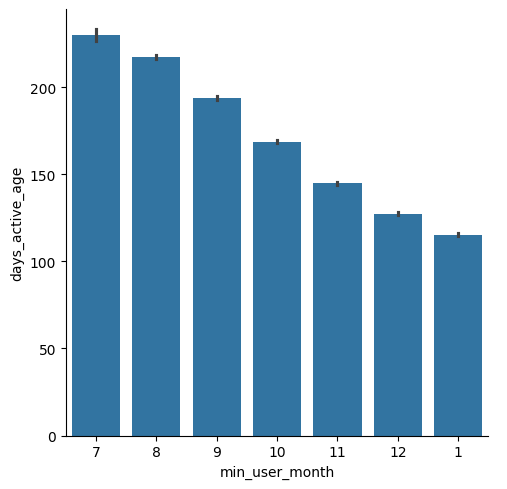

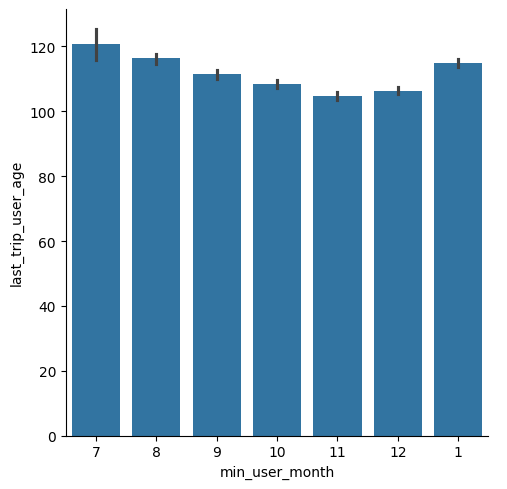

In [45]:
sns.catplot(data = cohort, x = 'min_user_month', y = 'days_active_age', kind = 'bar')
sns.catplot(data = cohort, x = 'min_user_month', y = 'last_trip_user_age', kind = 'bar')
plt.show()

In [40]:
grouped_cohort = cohort.groupby('min_user_month', observed=True).agg(
    cnt_user = ('user_id', 'nunique'),
    page_clicks = ('page_clicks', 'sum'),
    cnt_trips = ('cnt_trips', 'sum'),
    last_trip_user_age = ('last_trip_user_age', 'mean'),
    days_active_age = ('days_active_age', 'mean')
).reset_index()
grouped_cohort

,min_user_month,cnt_user,page_clicks,cnt_trips,last_trip_user_age,days_active_age
0,7,1851,200495,3804,120.759807,229.780119
1,8,14089,1456910,28198,116.312719,217.379019
2,9,13673,1315447,25926,111.483242,193.774665
3,10,15287,1399883,26566,108.393251,168.602342
4,11,15948,1377210,24671,104.772176,144.779910
5,12,14950,1183168,18422,106.414702,127.306689
6,1,8781,604761,6421,114.976400,115.296549


In [38]:
# count monthly active user for each cohort

cohort_grouped = cohort.groupby(
    ['min_user_month', 'cohort_index'], observed=True
).agg(
    cnt_user=('user_id', 'nunique')
).reset_index()

cohort_counts = cohort_grouped.pivot(index = 'min_user_month', columns = 'cohort_index', values = 'cnt_user')

display(cohort_counts)

cohort_index,1.0,2.0,3.0,4.0,5.0,6.0,7.0
min_user_month,,,,,,,
7,80.0,221.0,128.0,153.0,271.0,278.0,526.0
8,1410.0,1160.0,1268.0,2142.0,2246.0,4338.0,NaN
9,1359.0,1258.0,2255.0,2403.0,4719.0,NaN,NaN
10,1795.0,2853.0,2946.0,5652.0,NaN,NaN,NaN
11,2982.0,3795.0,6672.0,NaN,NaN,NaN,NaN
12,4325.0,7510.0,NaN,NaN,NaN,NaN,NaN
1,5466.0,NaN,NaN,NaN,NaN,NaN,NaN
